In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from tqdm.notebook import tqdm
import re

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
#import torch.optim as optim

In [3]:
import NegativeClassOptimization.config as config
import NegativeClassOptimization.datasets as datasets
from NegativeClassOptimization.preprocessing import onehot_encode_df, get_one_hot_aa_encoder

In [4]:
from captum.attr import IntegratedGradients

In [5]:
from modif_utils import *

In [6]:
ONE_VS_ALL_PATH = Path('../data/full_data/1_vs_all')
PAIRWISE_HIGH_PATH = Path('../data/full_data/high_pairwise')
HIGH_LOW_PATH = Path('../data/full_data/high_low_concat')

In [63]:
def get_aa_degree(y_deg):
    y_deg = [*y_deg[:-1]]
    n = 2
    y_deg = [y_deg[i: i+n] for i in range(0, len(y_deg), n)]
    return y_deg
def full_slide_degree(y_slide, y_deg):
    y_slide = [*y_slide]
    y_deg =  get_aa_degree(y_deg)
    j = 0
    deg_full = []
    for i in range(len(y_slide)):
        if y_slide[i] == y_deg[j][0]:
            aa_deg = ''.join(y_deg[j])
            if j < len(y_deg)-1:
                j +=1
        else:
            aa_deg = y_slide[i] +'0'
        deg_full.append(aa_deg)
    return deg_full

In [64]:
antigens = ['3VRL', '1NSN', '3RAJ', '5E94', '1H0D', '1WEJ', '1ADQ', '1FBI','2YPV', '1OB1']  

In [67]:
converter = {f"1_vs_all_repl_{d}_ig": pd.eval for d in range(1,11)}

In [ ]:
ag = '3VRL'
df_imp_pred = pd.read_csv(f'./logs/{ag}_swa_1_vs_all_ig.txt', sep='\t', converters = converter, index_col = 0)
df_imp_pred['full_deg_Slide'] = df_imp_pred['full_deg_Slide'].apply(eval)
df_igs = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig"))

In [198]:
def draw_repl_heatmap(df_imp_pred, slide, vmax, vmin, picture_name = False):
    repl_acc = []
    for i in range(1,11):
        y_pred = df_imp_pred[f'1_vs_all_repl_{i}_pred'].astype(bool)
        y_true = df_imp_pred['binder']
        acc = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
        repl_acc.append(f'repl {i} acc {round(acc,2)}')
    row = df_imp_pred[df_imp_pred['Slide'] == slide].index[0]
    repl_comp = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig")).iloc[row]
    repl_comp = repl_comp.apply(pd.eval)
    columns = df_imp_pred.iloc[row]['full_deg_Slide']
    columns = eval(columns)
    repl_comp = pd.DataFrame(repl_comp.to_list(), columns = columns, index = repl_acc)
    repl_comp = repl_comp.astype(float)
    sns.clustermap(repl_comp, row_cluster = True, col_cluster = False, figsize= (8,7),\
                   vmax = vmax, vmin = vmin, cmap = "vlag")
    if picture_name:
        plt.savefig(picture_name)
    plt.show()

In [232]:
def vmax_vmin(df_imp_pred, slide):
    row = df_imp_pred[df_imp_pred['Slide'] == slide].index[0]
    repl_comp = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_ig")).iloc[row]
    repl_comp = repl_comp.apply(pd.eval)
    columns = df_imp_pred.iloc[row]['full_deg_Slide']
    columns = eval(columns)
    repl_comp = pd.DataFrame(repl_comp.to_list(), columns = columns, index = repl_acc)
    repl_comp = repl_comp.astype(float)
    vmin = repl_comp.values.min()
    vmax = repl_comp.values.max()
    return vmax, vmin

In [233]:
train_types = ['swa_1_vs_all_ig', 'base_1_vs_all_ig'] # 'swa_high_low_ig', 'swa_high_looser_ig'
ag_min_max = dict()
for ag in antigens:
    maxs = []
    mins = []
    for train_type in train_types:
        df_imp_pred = pd.read_csv(f'./logs/{ag}_{train_type}.txt', sep='\t', index_col = 0)
        #df_imp_pred['full_deg_Slide'] = df_imp_pred['full_deg_Slide'].apply(eval)
        slide = ag_slide[ag]
        vmax, vmin = vmax_vmin(df_imp_pred, slide)
        maxs.append(vmax)
        mins.append(vmin)
    ag_min_max[ag] = (max(maxs), min(mins)) 

In [234]:
ag_slide = dict()
for ag in antigens:
    sets_list = []
    for train_type in train_types:
        df_imp_pred = pd.read_csv(f'./logs/{ag}_{train_type}.txt', sep='\t', index_col = 0)
        corrects = df_imp_pred.filter(regex=("1_vs_all_repl_\d*_pred")).all(1.0)
        correct_slide = set(df_imp_pred[corrects]['Slide'].values)
        sets_list.append(correct_slide)
    slide_set = set.intersection(*sets_list) 
    ag_slide[ag] = list(slide_set)[0]

In [235]:
ag_slide

{'3VRL': 'LGLLRLRLDYW',
 '1NSN': 'SLLYDYDWFAY',
 '3RAJ': 'FYYSNLAWFAY',
 '5E94': 'LHYYGSFFFDY',
 '1H0D': 'RIGYDGYYWYF',
 '1WEJ': 'CAWGILRLDYW',
 '1ADQ': 'EISLYYAMDYW',
 '1FBI': 'KVWELGLGWYF',
 '2YPV': 'ARSLYGLYWYF',
 '1OB1': 'MALYSLYAMDY'}

3VRL swa_1_vs_all_ig slide LGLLRLRLDYW


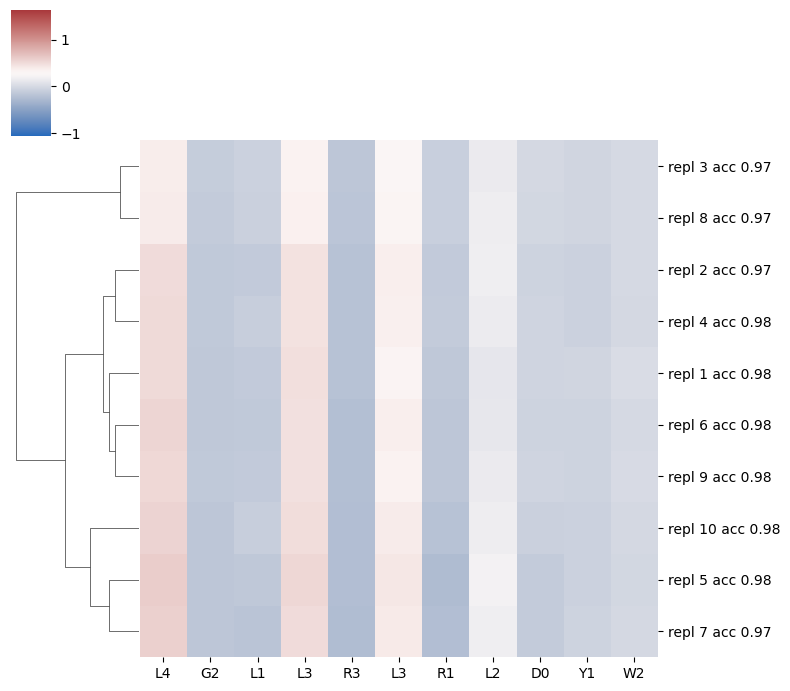

3VRL base_1_vs_all_ig slide LGLLRLRLDYW


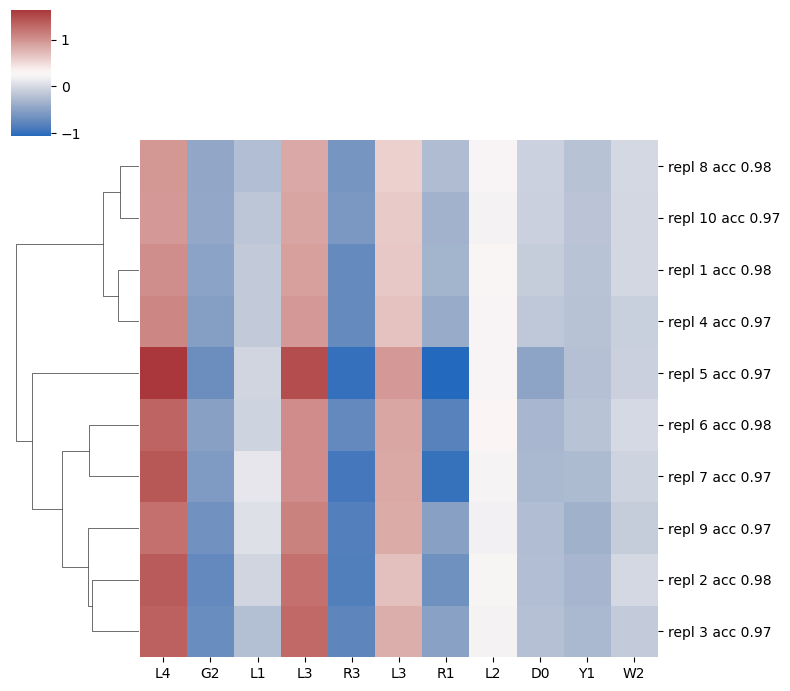

1NSN swa_1_vs_all_ig slide SLLYDYDWFAY


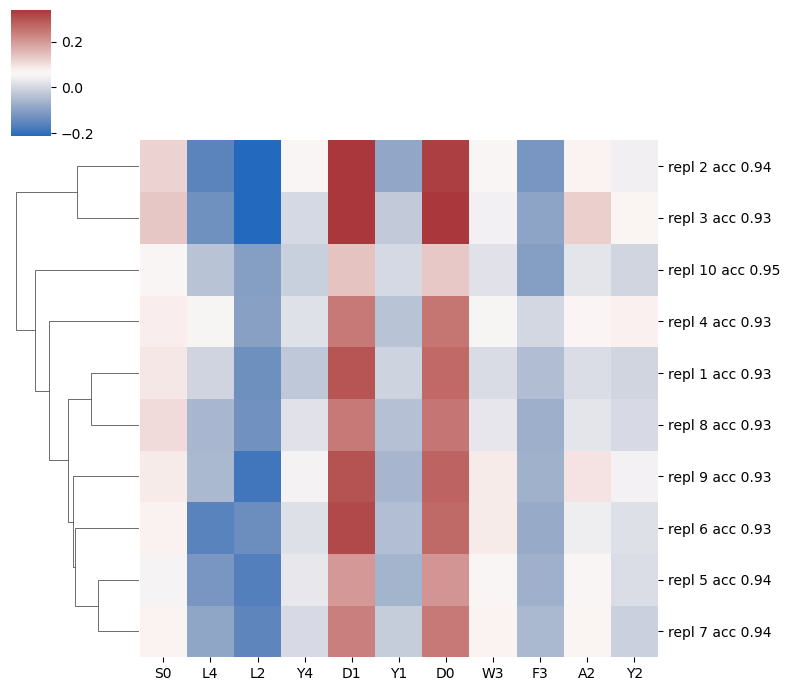

1NSN base_1_vs_all_ig slide SLLYDYDWFAY


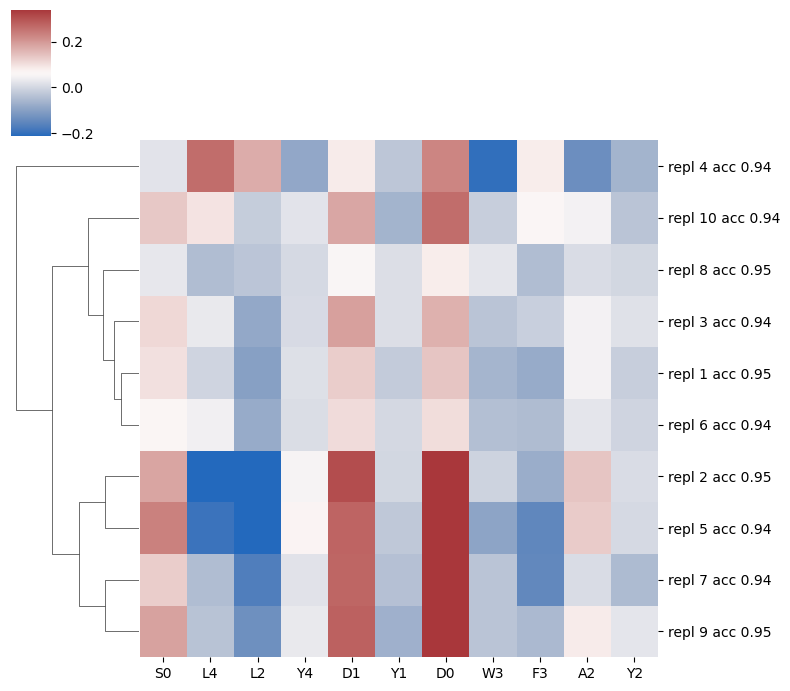

3RAJ swa_1_vs_all_ig slide FYYSNLAWFAY


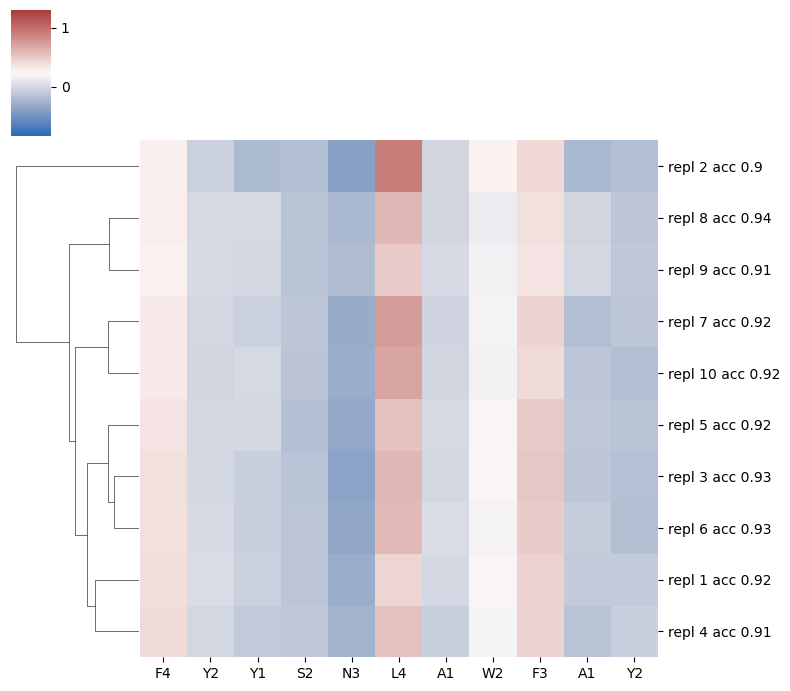

3RAJ base_1_vs_all_ig slide FYYSNLAWFAY


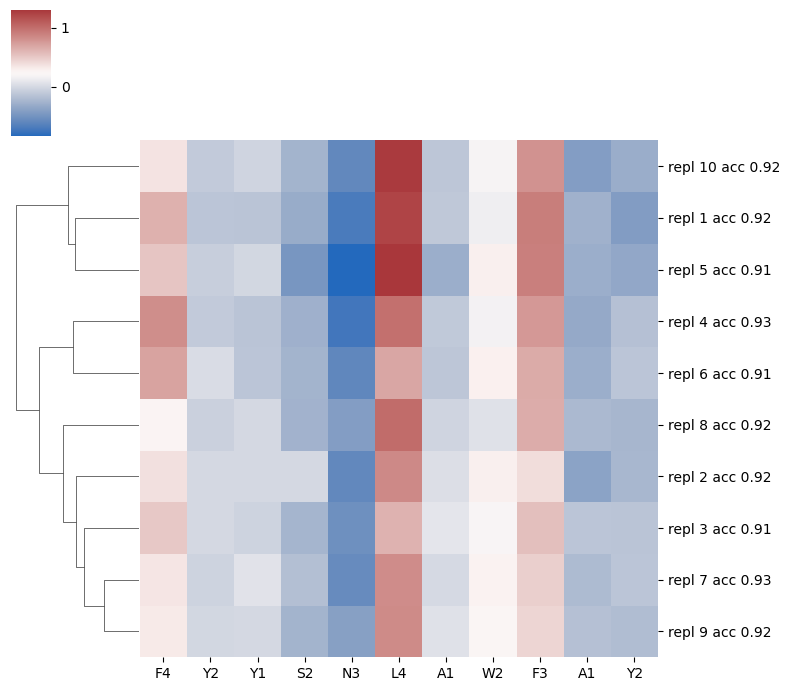

5E94 swa_1_vs_all_ig slide LHYYGSFFFDY


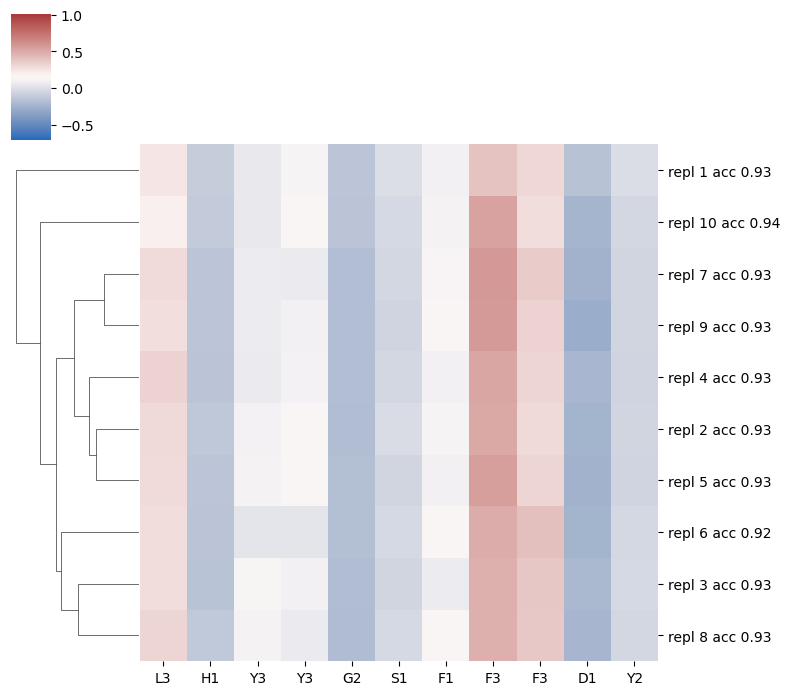

5E94 base_1_vs_all_ig slide LHYYGSFFFDY


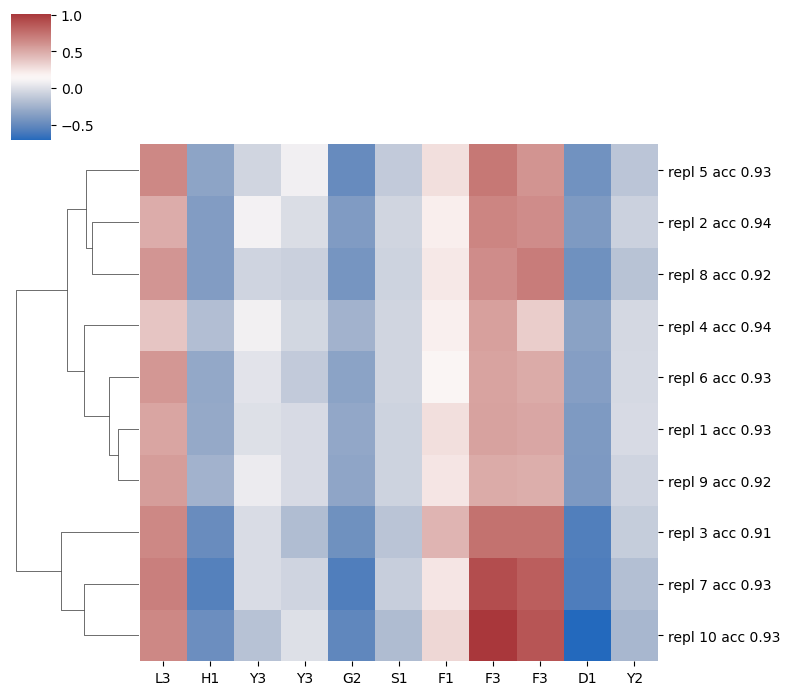

1H0D swa_1_vs_all_ig slide RIGYDGYYWYF


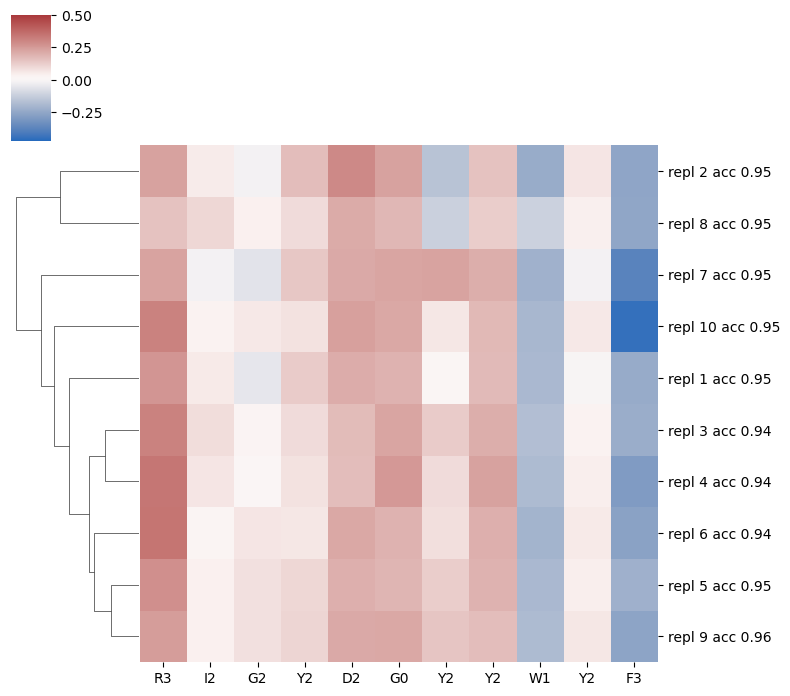

1H0D base_1_vs_all_ig slide RIGYDGYYWYF


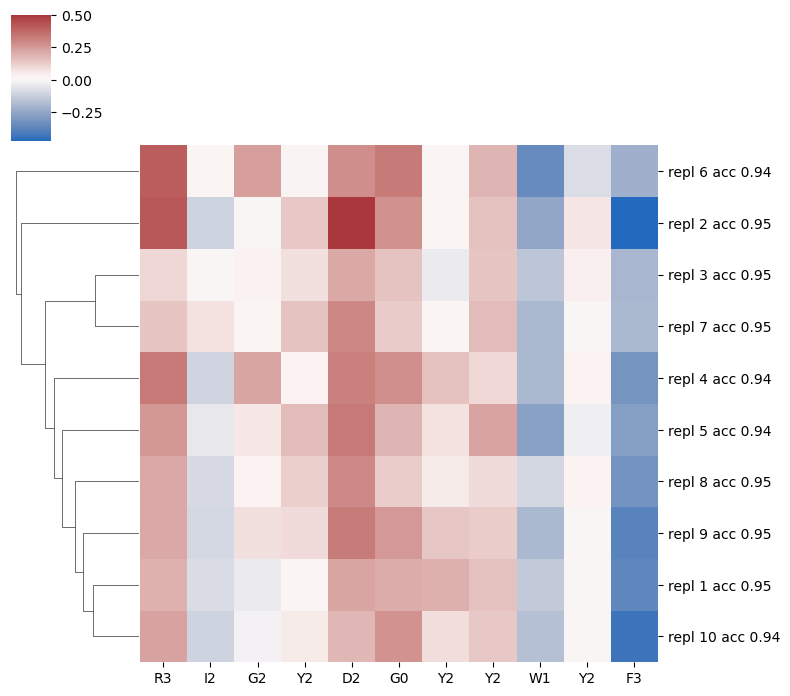

1WEJ swa_1_vs_all_ig slide CAWGILRLDYW


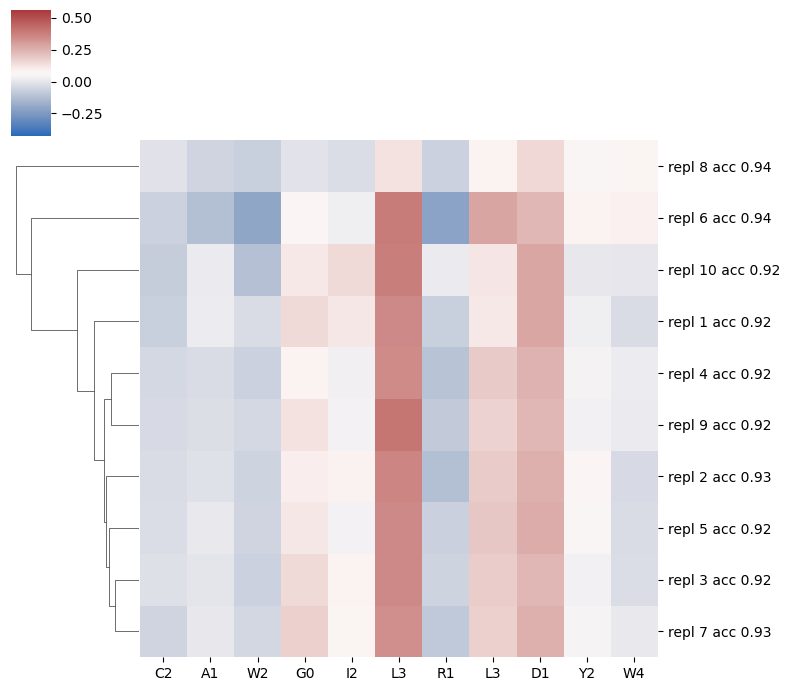

1WEJ base_1_vs_all_ig slide CAWGILRLDYW


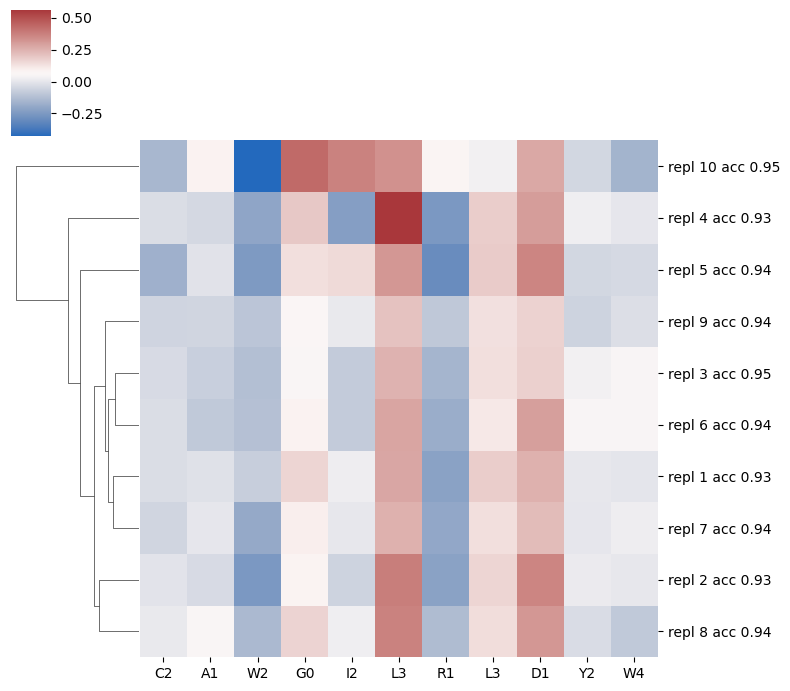

1ADQ swa_1_vs_all_ig slide EISLYYAMDYW


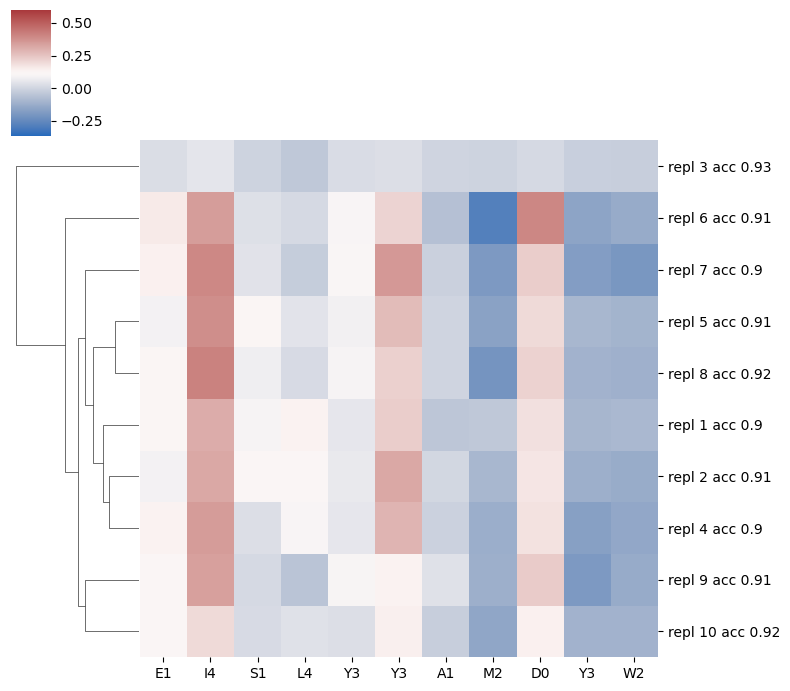

1ADQ base_1_vs_all_ig slide EISLYYAMDYW


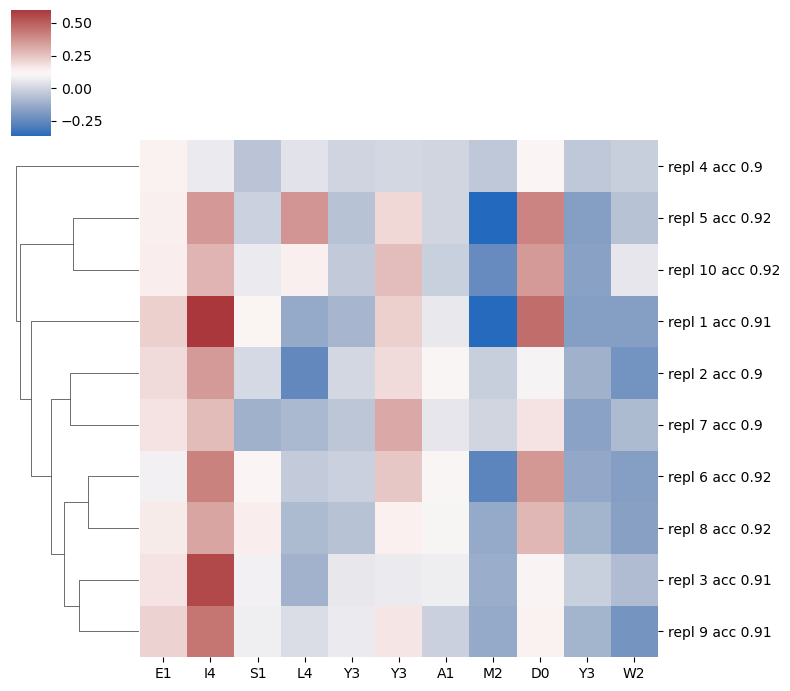

1FBI swa_1_vs_all_ig slide KVWELGLGWYF


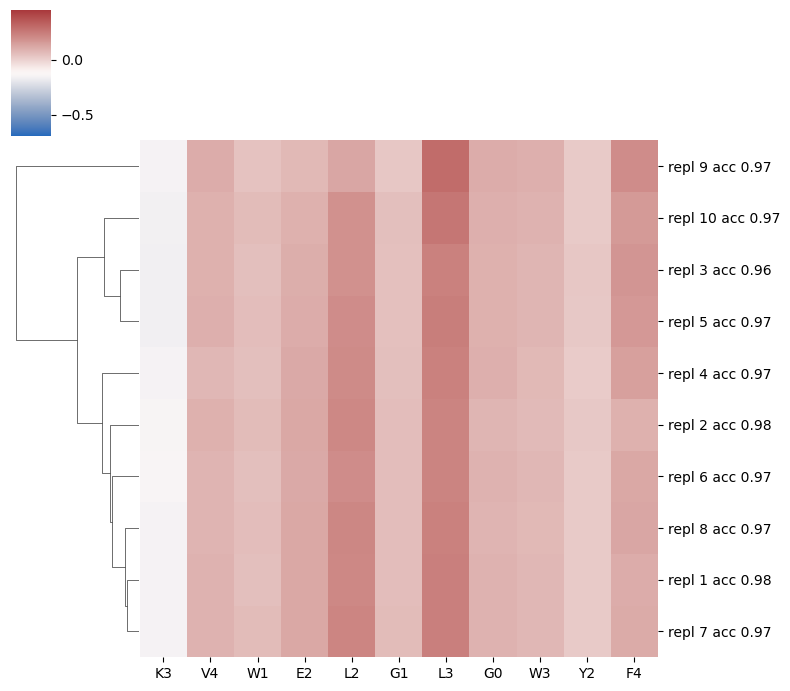

1FBI base_1_vs_all_ig slide KVWELGLGWYF


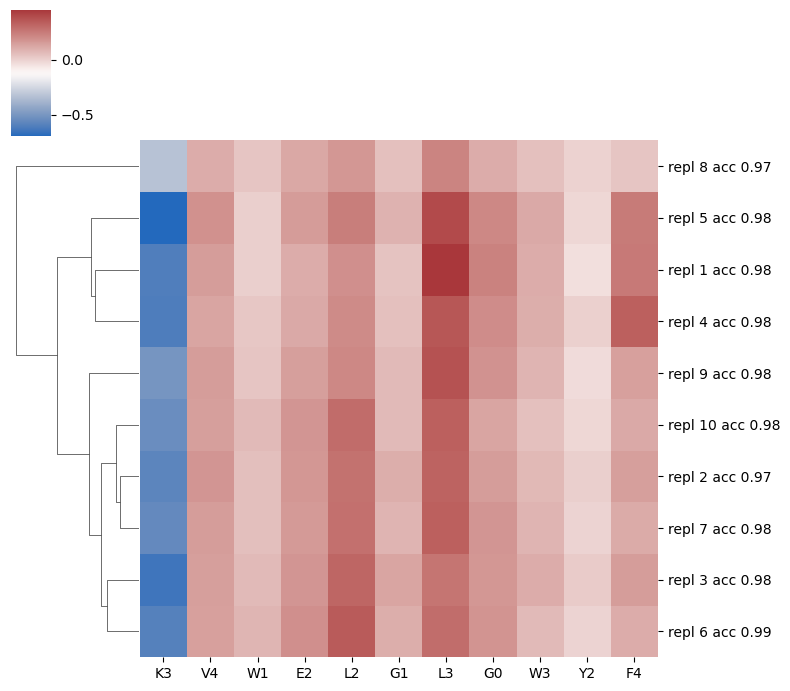

2YPV swa_1_vs_all_ig slide ARSLYGLYWYF


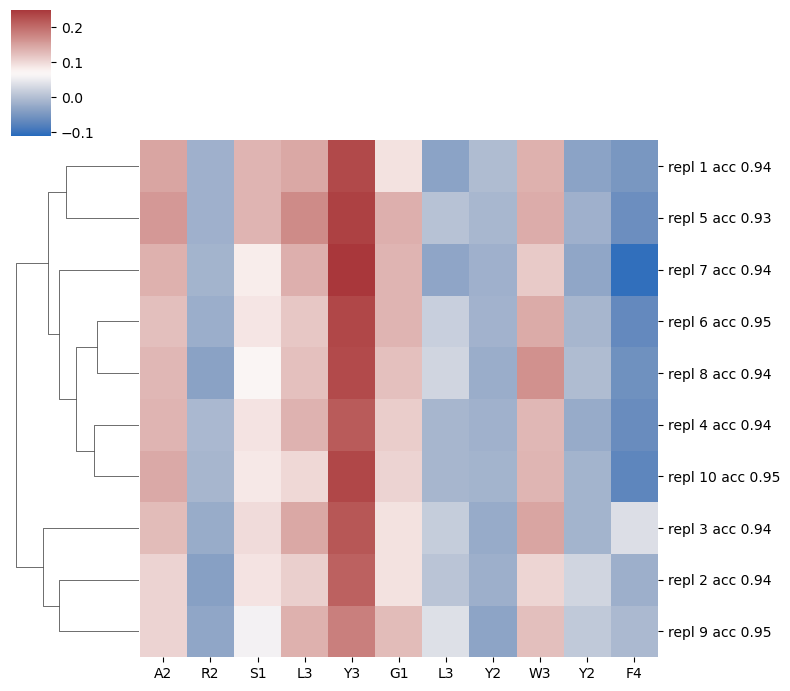

2YPV base_1_vs_all_ig slide ARSLYGLYWYF


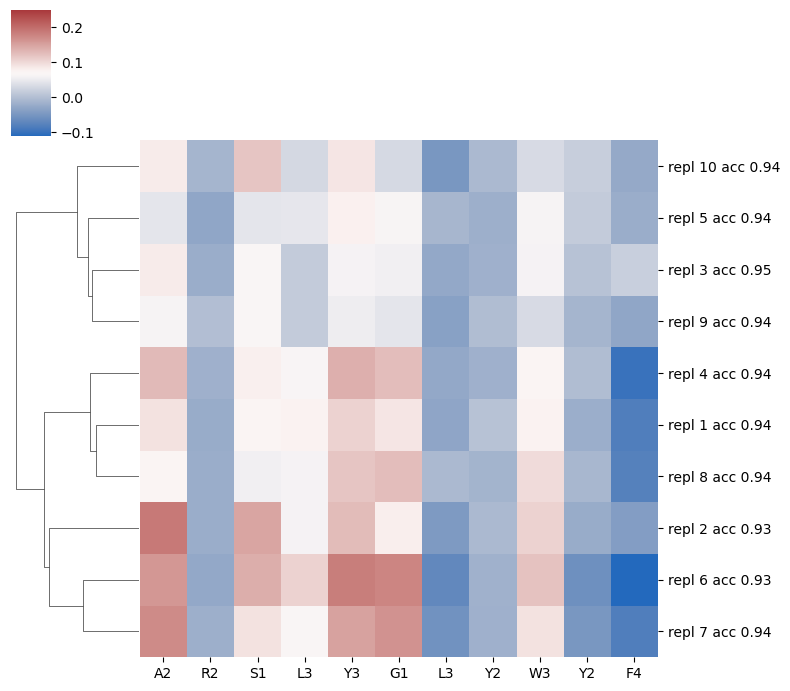

1OB1 swa_1_vs_all_ig slide MALYSLYAMDY


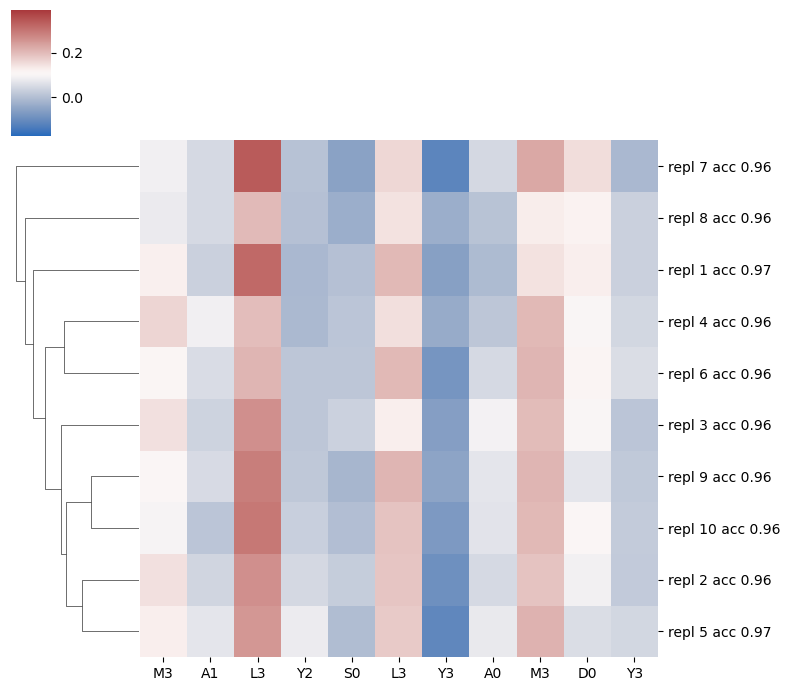

1OB1 base_1_vs_all_ig slide MALYSLYAMDY


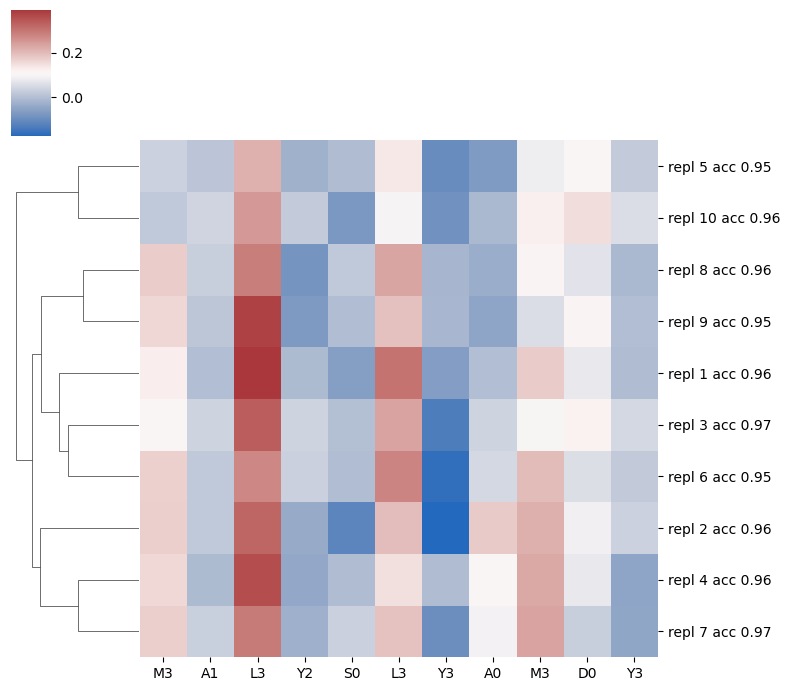

In [236]:
train_types = ['swa_1_vs_all_ig', 'base_1_vs_all_ig']#, 'swa_high_low_ig', 'swa_high_looser_ig'
for ag in antigens:
    for train_type in train_types:
        df_imp_pred = pd.read_csv(f'./logs/{ag}_{train_type}.txt', sep='\t', index_col = 0)
        #df_imp_pred['full_deg_Slide'] = df_imp_pred['full_deg_Slide'].apply(eval)
        slide = ag_slide[ag]
        vmax, vmin = ag_min_max[ag]
        print(f'{ag} {train_type} slide {slide}')
        draw_repl_heatmap(df_imp_pred, slide,vmax, vmin, picture_name = f'{ag}_{train_type}_slide_{slide}')